In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette(['#376CA8', '#25A37B', '#E44574', '#796E9C'])

sns.set_context('paper')

# Note that these are not my standard settings
sns.set_style({
   'axes.axisbelow': True, 
   'axes.edgecolor': '.15', 
   'axes.facecolor': 'white',
   'axes.grid': True, 
   'axes.labelcolor': '.15',
   'axes.labelsize': 5,
   'axes.linewidth': 0.5, 
   'axes.spines.right': False, 
   'axes.spines.top': False,  
   'axes.titlesize': 5,
   'figure.facecolor': 'white', 
   'font.family': ['sans-serif'], 
   'grid.color': '.15',
   'grid.linestyle': ':', 
   'grid.linewidth': 0.1,
   'grid.alpha': .5, 
   'image.cmap': 'Greys', 
   'legend.frameon': False, 
   'legend.fontsize': 5,
   'legend.numpoints': 1, 
   'legend.scatterpoints': 1,
   'lines.solid_capstyle': 'round', 
   
   'text.color': '.15',  
   'xtick.top': False, 
   'ytick.right': False, 
})

for tick in ['xtick', 'ytick']:
    sns.set_style({
        f'{tick}.color': '.15',
        f'{tick}.direction': 'out', 
        f'{tick}.labelsize': 5,
        
        f'{tick}.major.pad': 2,
        f'{tick}.major.size': 2, 
        f'{tick}.major.width': 0.5,
        
        f'{tick}.minor.size': 1.5,
        f'{tick}.minor.width': 0.2,
        f'{tick}.minor.pad': 2,
        
    })
    
#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    
def output_path(basename):
    return os.path.join(OUTPUT_DIRECTORY, basename)

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

In [4]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE, FC_THRESHOLD_RESPONSE
from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER

In [5]:
palette_ptms = {
    'h2az': '#584A87',
    'me1': '#BBE1BB',
    'me2': '#9FBA7D',
    'me3': '#6F9979',
    'm5c': '#85B3B2',
    'ac': '#40678E'
}

palette = {
   'H2A.Z': palette_ptms['h2az'],
   'DNA Methylation': palette_ptms['m5c'],
}
for predictor in PREDICTOR_ORDER:
    
    if predictor.endswith('ac'):
        palette[predictor] = palette_ptms['ac']
    elif predictor[-3:] in ['me1', 'me2', 'me3']:
        palette[predictor] = palette_ptms[predictor[-3:]]


In [6]:
def human_label(row):
    
    if not row['significant']:
        return 'n.s.'
    elif row['significant_and_large_fc']:
        if row['logFC'] > 0:
            return f'≥ {FC_THRESHOLD_RESPONSE}'
        elif row['logFC'] < 0:
            return f'≤ -{FC_THRESHOLD_RESPONSE}'
    else:
        if row['logFC'] > 0:
            return f'0 to {FC_THRESHOLD_RESPONSE}'
        else:
            return f'-{FC_THRESHOLD_RESPONSE} to 0'

    

In [7]:
data_full = load_limma_data()
data_full['Effect'] = data_full.apply(human_label, axis=1)

In [8]:
data_full['Effect'].value_counts()

n.s.         19819
0 to 1.0      1277
-1.0 to 0      693
≥ 1.0          457
≤ -1.0         120
Name: Effect, dtype: int64

In [9]:
count_matrix = data_full.reset_index().groupby(['predictor', 'Effect']).size().unstack('Effect').fillna(0).astype(int)
count_matrix = count_matrix.reindex(index=PREDICTOR_ORDER, 
                                    columns=['≤ -1.0', '-1.0 to 0', 
                                             'n.s.', 
                                             '0 to 1.0', '≥ 1.0'])

In [10]:
count_matrix

Effect,≤ -1.0,-1.0 to 0,n.s.,0 to 1.0,≥ 1.0
predictor,,,,,
H2A.Z,11,36,1496,54,17
H3ac,1,178,923,362,120
H3K4me1,3,30,1629,4,1
H3K4me3,32,31,1501,31,45
H3K9acK14ac,0,134,1231,236,45
H3K9me2,0,1,1000,11,11
H3K9me3,0,4,1638,37,22
H3K27ac,0,1,1059,3,9
H3K27me2,0,0,1059,3,6


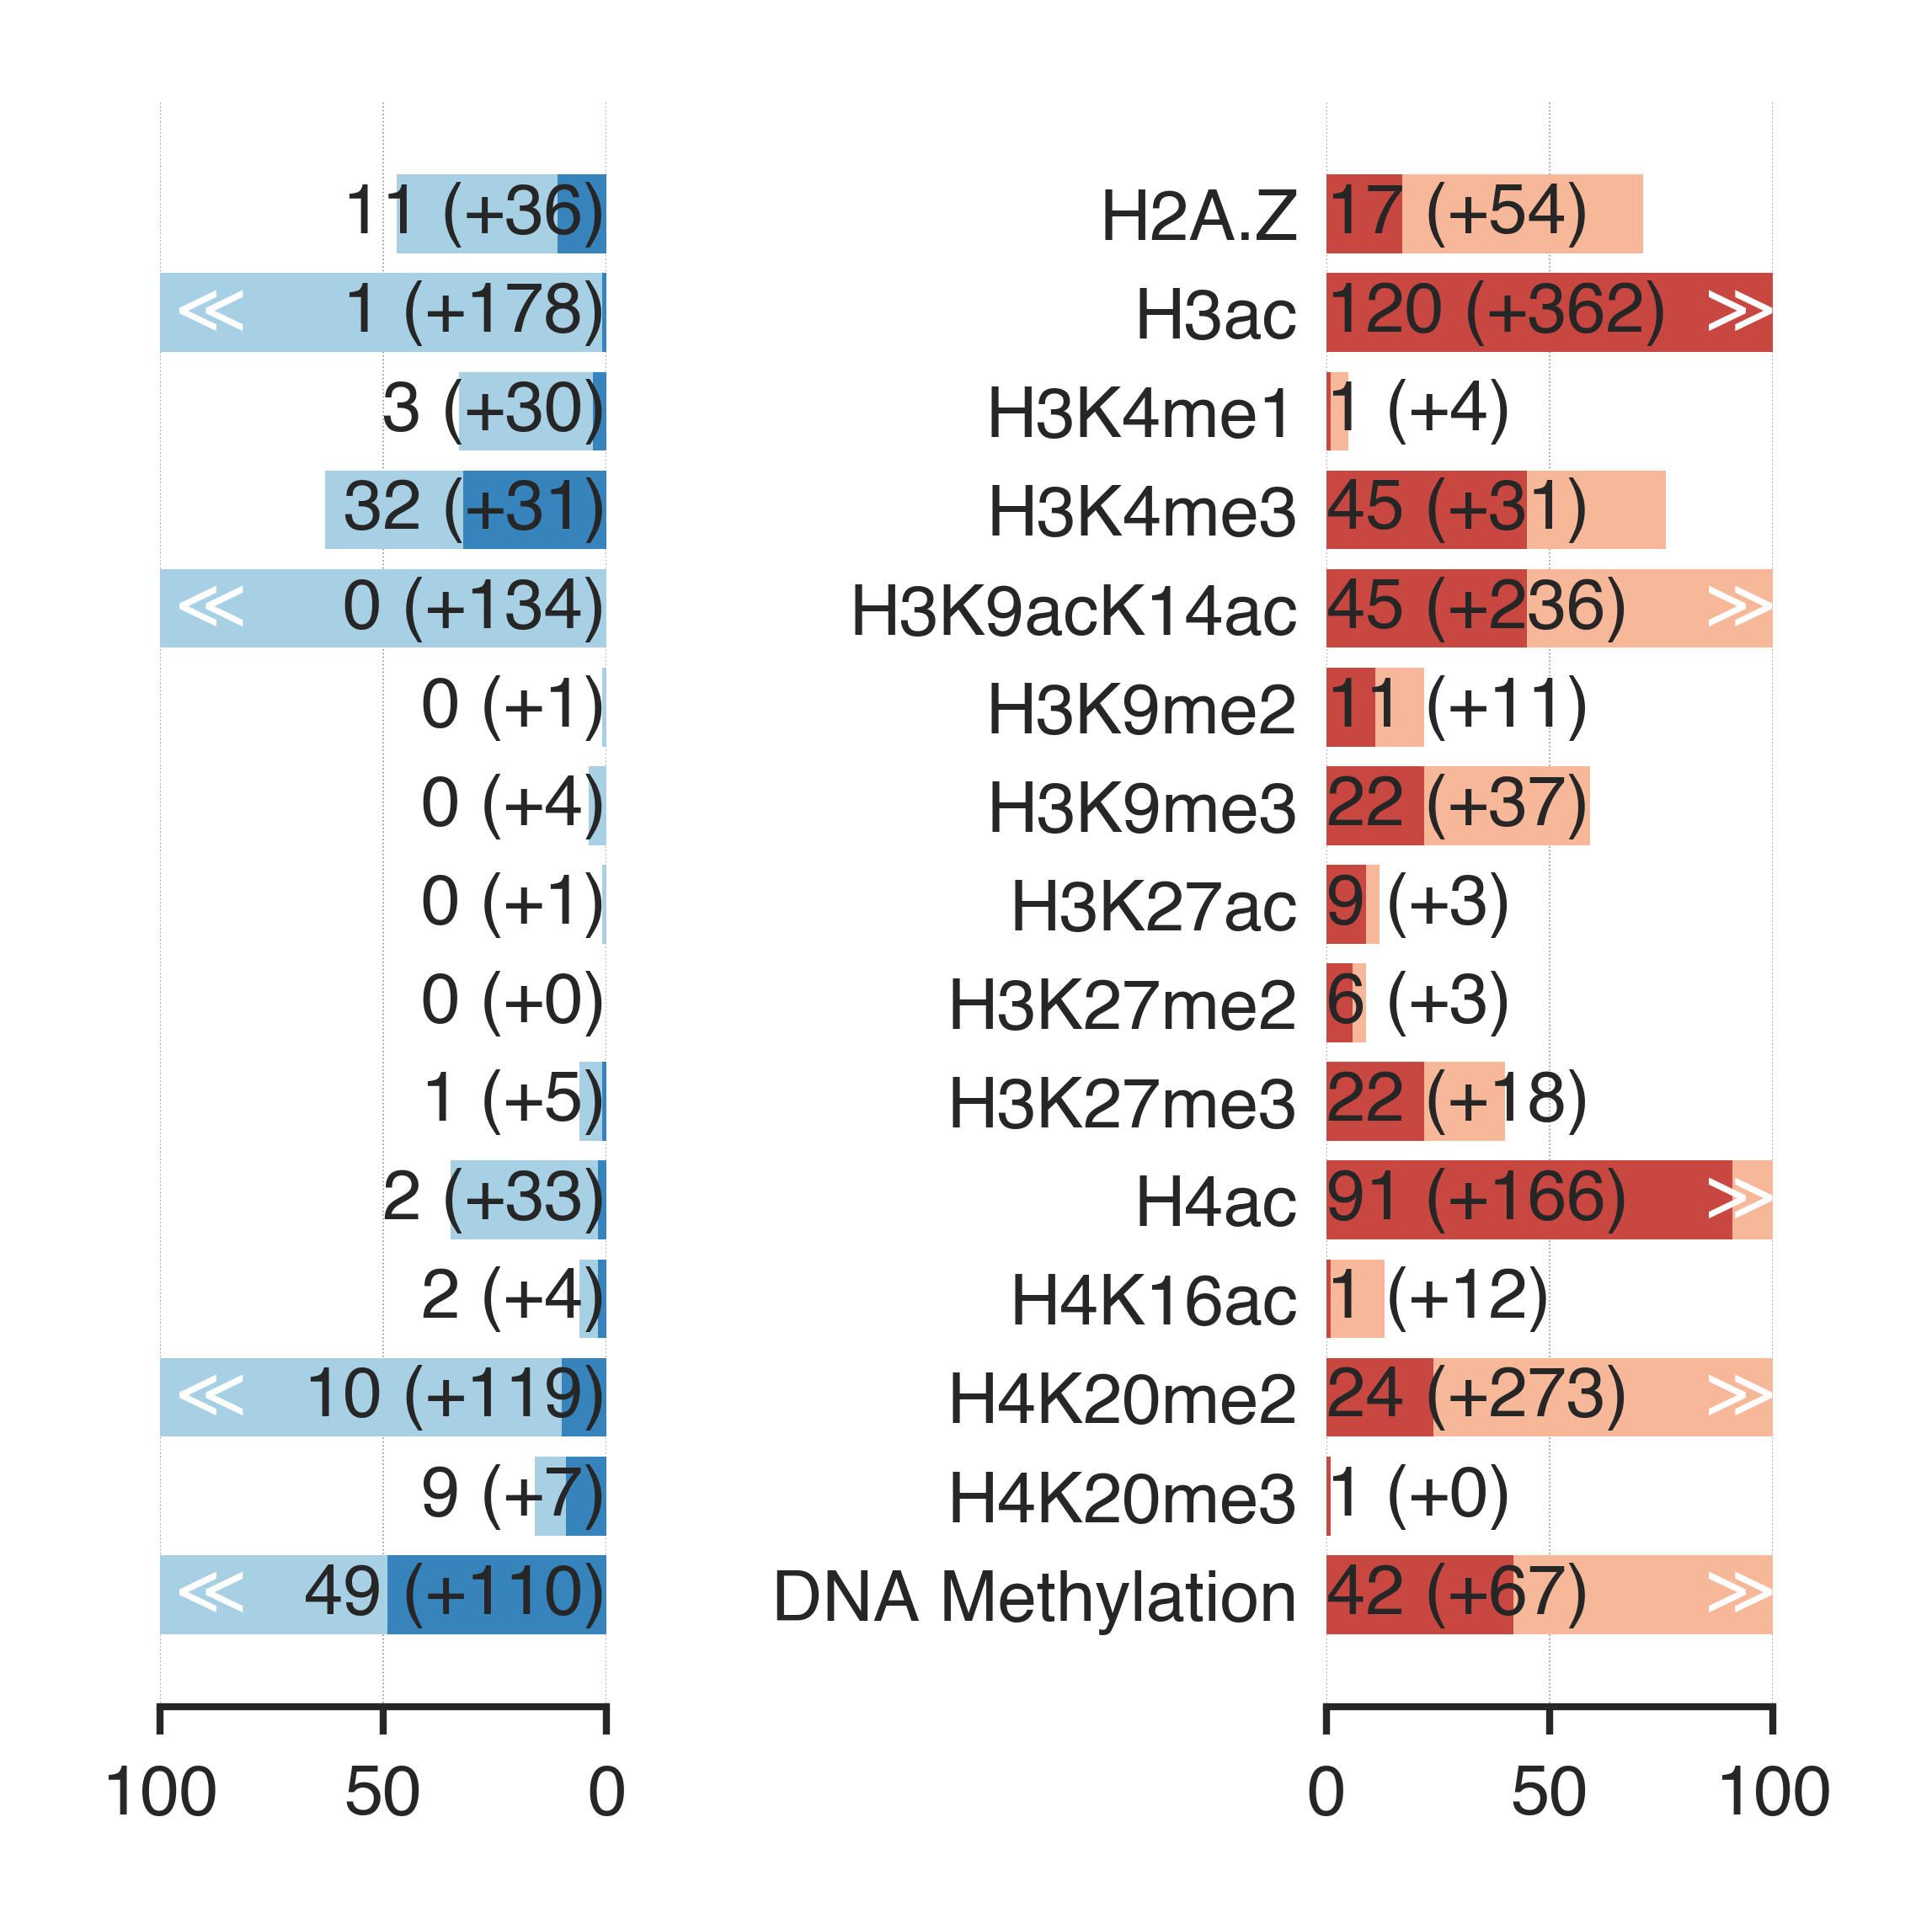

In [11]:
from matplotlib.ticker import LogLocator, NullFormatter

xlim = 100

fig = plt.figure(figsize=(2,2), dpi=600)

ax_left = fig.add_subplot(1, 2, 1)
ax_right = fig.add_subplot(1, 2, 2, sharey=ax_left)

palette = sns.color_palette('RdBu_r', 5).as_hex()


_df = count_matrix.copy()
_df = _df.iloc[::-1]

ax_left.barh(_df.index, _df['≤ -1.0'], color=palette[0])
ax_left.barh(_df.index, _df['-1.0 to 0'], 
             left=_df['≤ -1.0'], color=palette[1])

ax_right.barh(_df.index, _df['≥ 1.0'], color=palette[-1])
ax_right.barh(_df.index, _df['0 to 1.0'], 
              left=_df['≥ 1.0'], color=palette[-2])


fontsize = 5
for ix, row in _df.iterrows():
    
    ax_right.text(0, ix, '{:,} (+{:,})'.format(row['≥ 1.0'], row['0 to 1.0']),
                  ha='left', va='center',
                  fontsize=fontsize)
    ax_left.text(0, ix, '{:,} (+{:,})'.format(row['≤ -1.0'], row['-1.0 to 0']), 
                 ha='right', va='center',
                 fontsize=fontsize)
    
    if row[['≥ 1.0', '0 to 1.0']].sum() > xlim:
        ax_right.text(xlim, ix, '$\gg$', 
                      ha='right', va='center',
                      color='white', 
                      fontsize=fontsize)
        
    if row[['≤ -1.0', '-1.0 to 0']].sum() > xlim:
        ax_left.text(xlim, ix, '$\ll$', 
                     ha='left', va='center',
                     color='white', 
                     fontsize=fontsize)


ax_left.invert_xaxis()

# ax_right.set_xscale('log')
# ax_left.set_xscale('log')

sns.despine(left=True, right=True, ax=ax_left)
sns.despine(ax=ax_right, left=True)

for tick in ax_left.yaxis.get_ticklabels():
    tick.set_visible(False)
    
ax_left.yaxis.set_tick_params(length=0)
ax_right.yaxis.set_tick_params(length=0)

ax_left.set_xlim([xlim, 0])
ax_right.set_xlim([0, xlim])

ax_left.yaxis.grid(False)
ax_right.yaxis.grid(False)

ax_left.set_xticks([0, 50, 100])
ax_right.set_xticks([0, 50, 100])

plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts-barplots.pdf'), bbox_inches='tight')

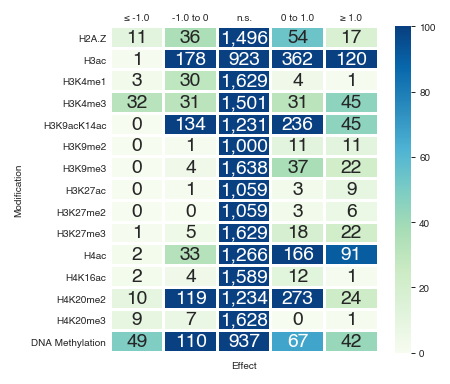

In [12]:
fig = plt.figure(figsize=(3, 3))
ax = plt.gca()
sns.heatmap(count_matrix, cmap='GnBu', vmax=100, fmt=',', annot=True, ax=ax, linewidth=1)

ax.yaxis.set_tick_params(length=0)

ax.xaxis.tick_top()
ax.xaxis.set_tick_params(length=0)

ax.set_ylabel('Modification')


plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts.pdf'), bbox_inches='tight')

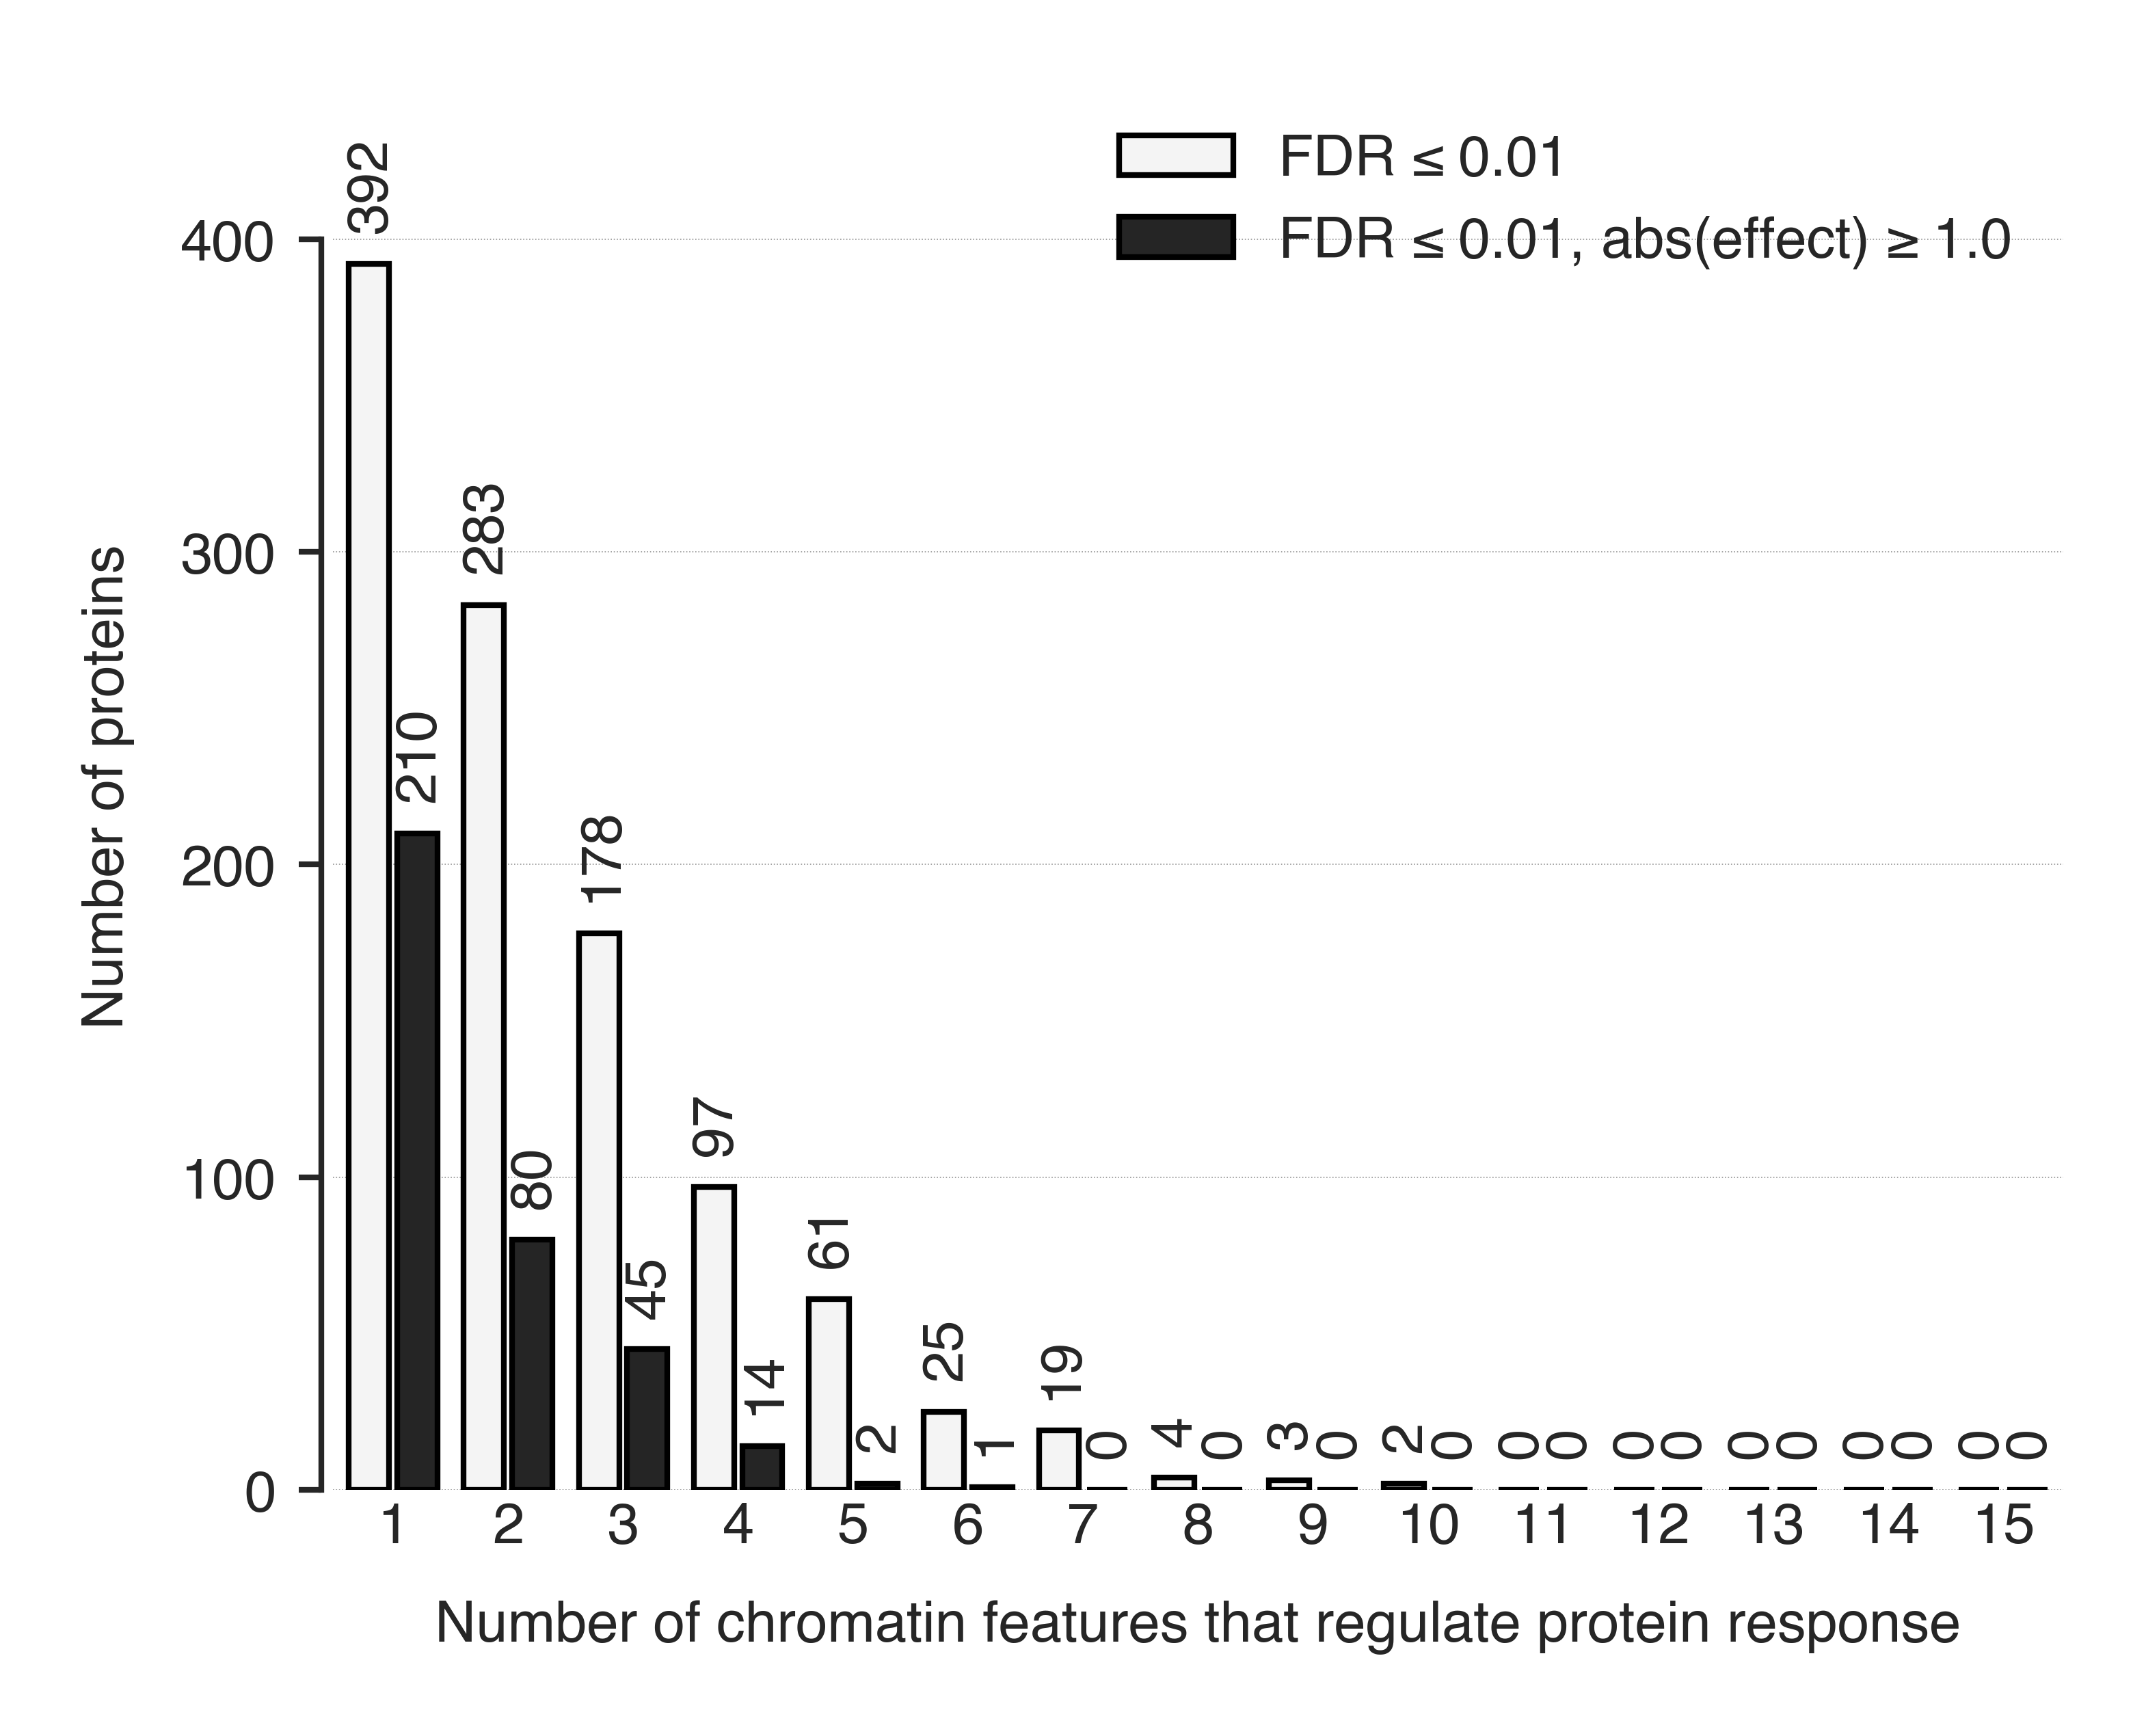

In [13]:
from matplotlib import gridspec


df = data_full[['significant', 'significant_and_large_fc']].fillna(False)
df = df.groupby(level='Gene label')['significant', 'significant_and_large_fc'].sum()
df = df.astype(int)

n_predictors = data_full.index.get_level_values('predictor').nunique()

significant_vcs = df['significant'].value_counts()
significant_and_large_fc_vcs = df['significant_and_large_fc'].value_counts()

# Reindex removing n=0, n=0 is inaccurate anyway as `data_full` lacks some proteins that were
# not considered for modelling.

count_range = list(range(1, n_predictors+1))

significant_vcs = significant_vcs.reindex(count_range).fillna(0)
significant_and_large_fc_vcs = significant_and_large_fc_vcs.reindex(significant_vcs.index).fillna(0)



labelsize = 5

context = {
            'axes.linewidth': 0.5,
            'grid.linewidth': 0.1,
            'grid.linestyle': ':',
            'xtick.labelsize': labelsize,
            'ytick.labelsize': labelsize,
            'xtick.major.size': 0,
            'xtick.major.width': 0.5,
            'xtick.major.pad': 1,
            'xtick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'xtick.minor.pad': 2,

            'ytick.major.size': 2,
            'ytick.major.width': 0.5,
            'ytick.major.pad': 2,
            'ytick.minor.size': 1.5,
            'ytick.minor.width': 0.2,
            'ytick.minor.pad': 2,
        }

with sns.plotting_context(context):

    fig = plt.figure(
        figsize=(2.5, 2), 
        dpi=600,
        constrained_layout=True,
    )

    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

    ax_significant = fig.add_subplot(gs[0, 0])
    # ax_significant_and_large_fc = fig.add_subplot(gs[0, 1], sharex=ax_significant, sharey=ax_significant)

    barplot_width = 0.35
    barplot_kwargs = dict(width=barplot_width, edgecolor='black', linewidth=0.5)
    
    barplot_offset = (barplot_width / 2)*1.2
    ax_significant.bar(significant_vcs.index - barplot_offset, significant_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}",
                       color='#F4F4F4', **barplot_kwargs)
    ax_significant.bar(significant_and_large_fc_vcs.index + barplot_offset, significant_and_large_fc_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}, abs(effect) ≥ {FC_THRESHOLD_RESPONSE}",
                       color='#252525', **barplot_kwargs)
    
    for i, value in significant_vcs.items():
        # The +(barplot_offset * 0.1) bit corrects for some weird alignment issue
        ax_significant.text(i-barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)
    
    for i, value in significant_and_large_fc_vcs.items():
        ax_significant.text(i+barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)

    ax_significant.set_xticks(count_range)
    ax_significant.set_xticklabels(count_range)
    ax_significant.xaxis.grid(False)
    
    ax_significant.legend(fontsize=labelsize)
    
    ax_significant.set_xlabel("Number of chromatin features that regulate protein response", fontsize=labelsize)
    ax_significant.set_ylabel("Number of proteins", fontsize=labelsize)
    
    ax_significant.set_xlim(count_range[0]-barplot_width*1.5, count_range[-1]+barplot_width*1.5)
    
    ax_significant.set_yticks([0, 100, 200, 300, 400])
    
    ax_significant.set_ylim(0, 450)
    
    
    sns.despine(ax=ax_significant, offset=1, bottom=True, trim=True)
    
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts-histogram.pdf'), dpi=300)


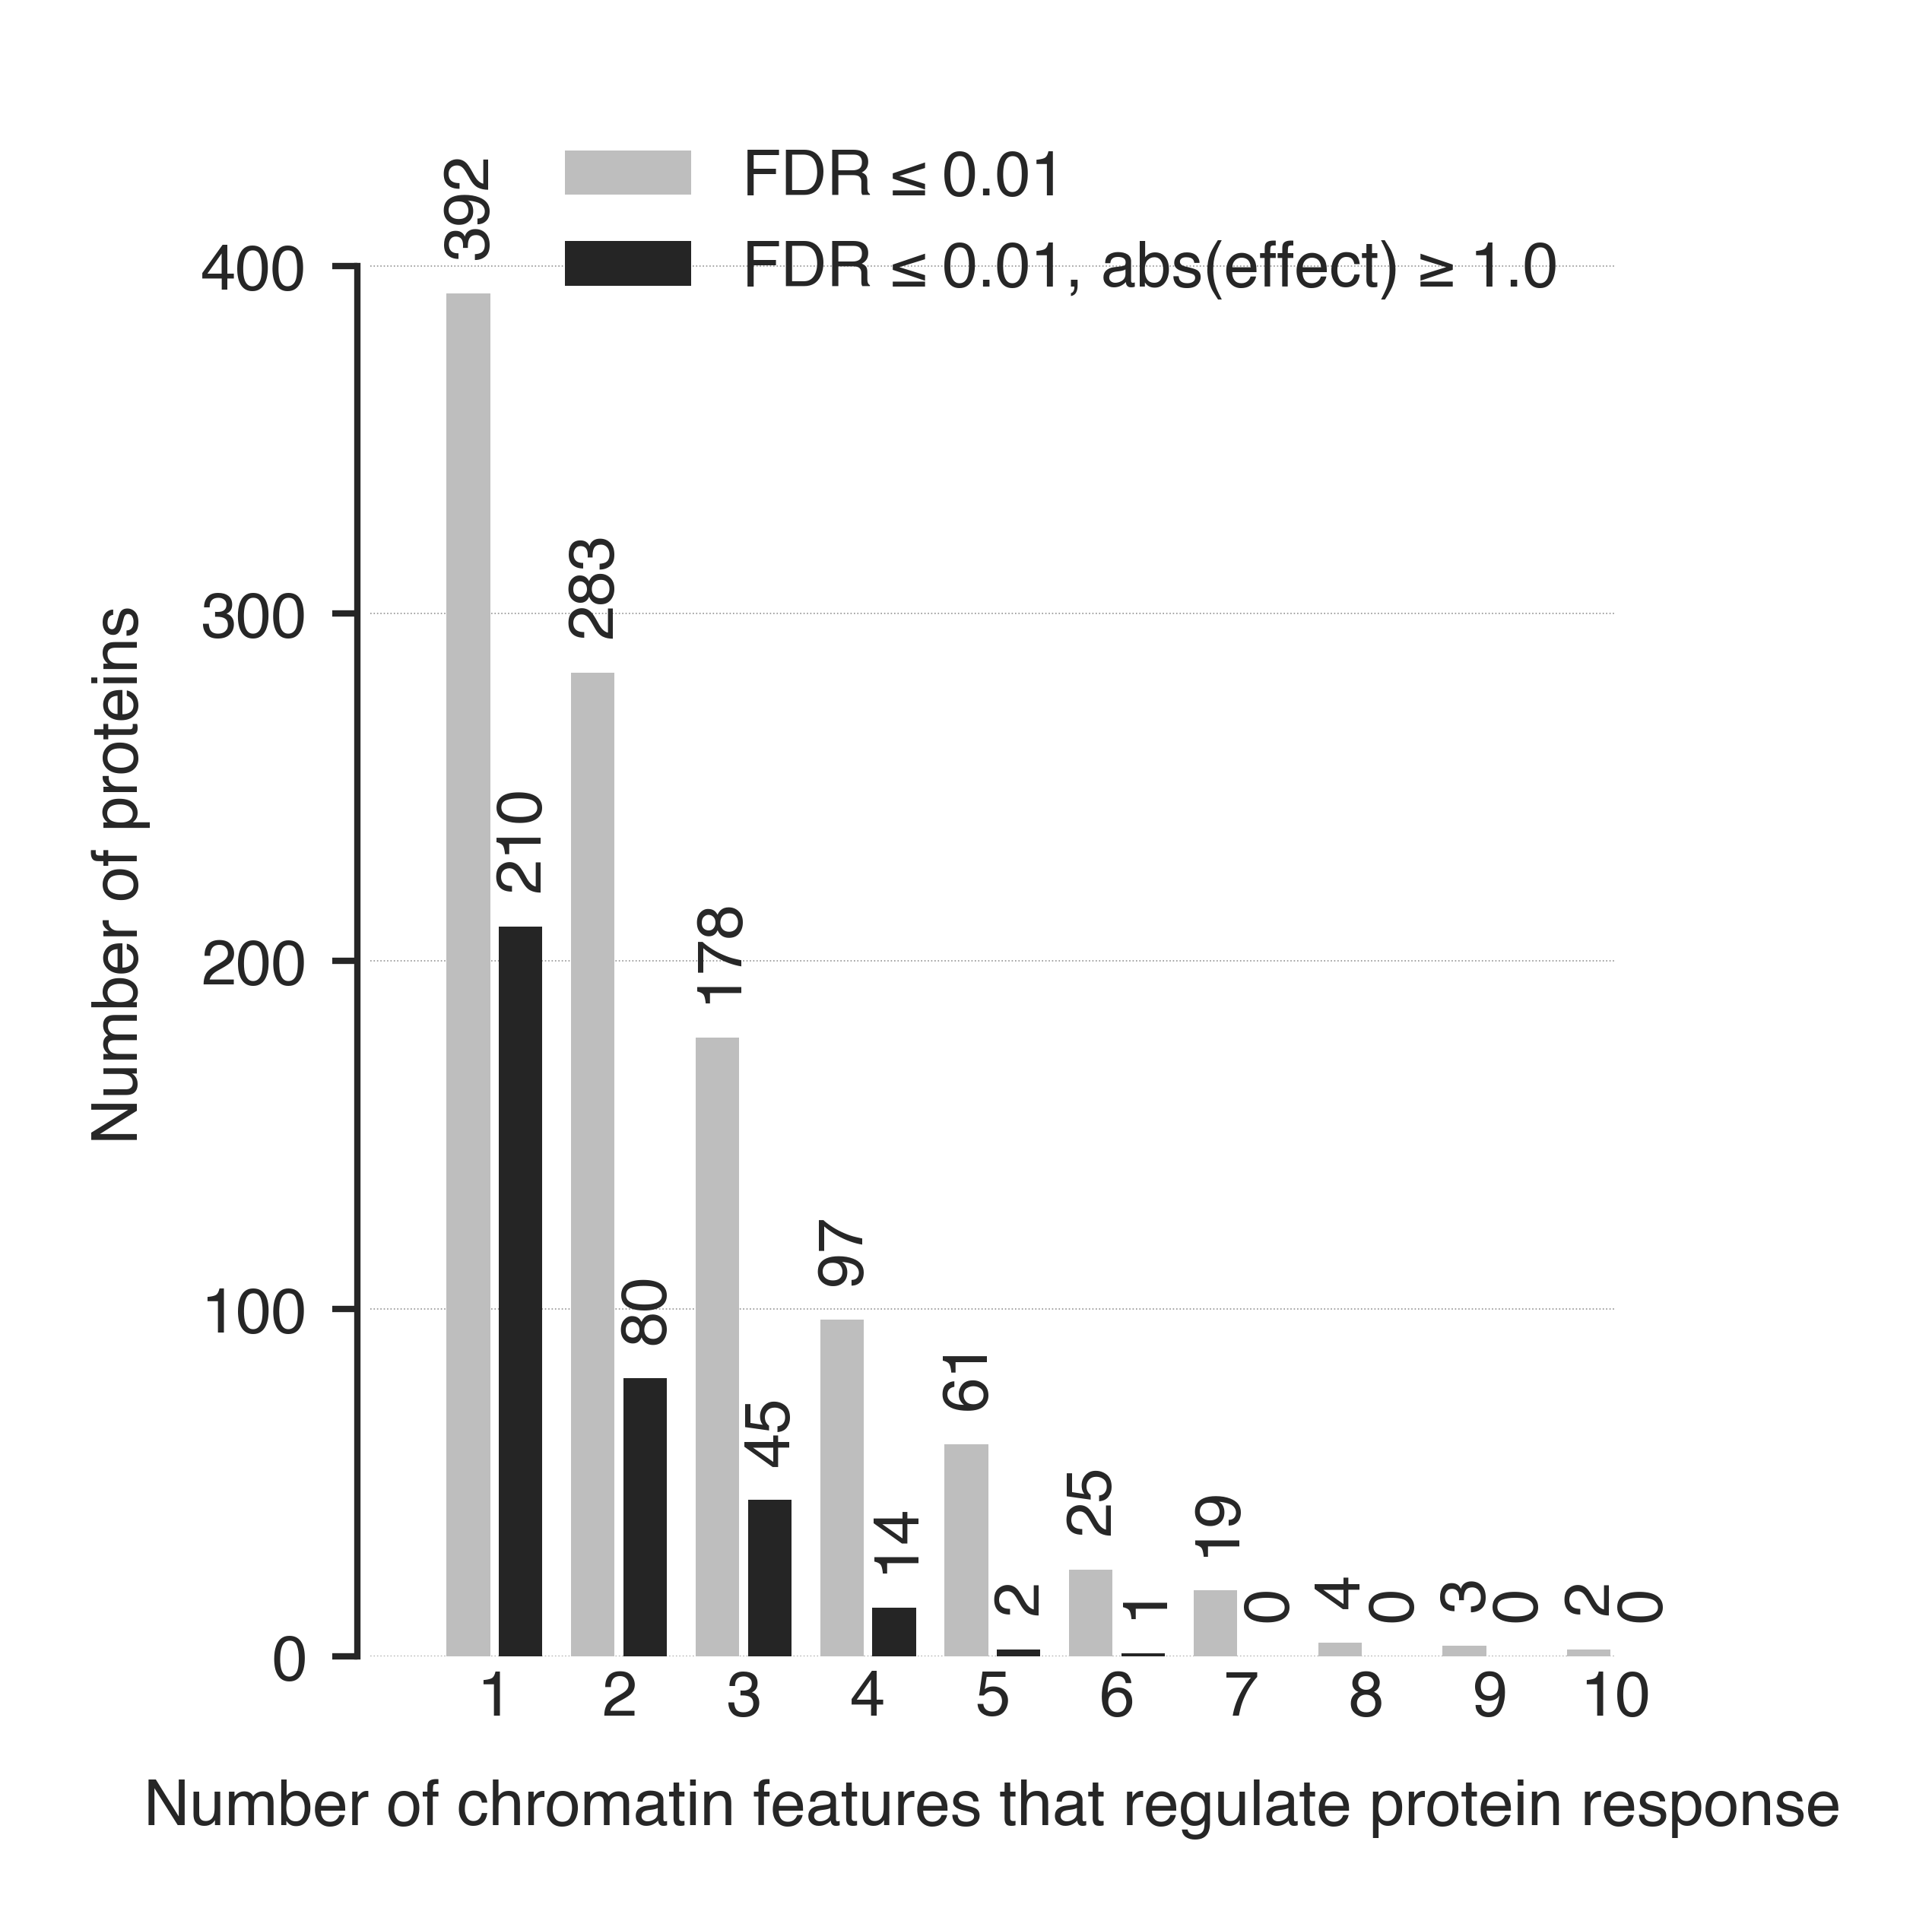

In [14]:
from matplotlib import gridspec


df = data_full[['significant', 'significant_and_large_fc']].fillna(False)
df = df.groupby(level='Gene label')['significant', 'significant_and_large_fc'].sum()
df = df.astype(int)

n_predictors = data_full.index.get_level_values('predictor').nunique()

significant_vcs = df['significant'].value_counts()
significant_and_large_fc_vcs = df['significant_and_large_fc'].value_counts()

# Reindex removing n=0, n=0 is inaccurate anyway as `data_full` lacks some proteins that were
# not considered for modelling.

count_range = list(range(1, n_predictors+1))

significant_vcs = significant_vcs.reindex(count_range).fillna(0)
significant_and_large_fc_vcs = significant_and_large_fc_vcs.reindex(significant_vcs.index).fillna(0)

max_count = significant_vcs.index[(significant_vcs + significant_and_large_fc_vcs) > 0].max()


labelsize = 5

context = {
            'axes.linewidth': 0.5,
            'grid.linewidth': 0.1,
            'grid.linestyle': ':',
            'xtick.labelsize': labelsize,
            'ytick.labelsize': labelsize,
            'xtick.major.size': 0,
            'xtick.major.width': 0.5,
            'xtick.major.pad': 1,
            'xtick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'xtick.minor.pad': 2,

            'ytick.major.size': 2,
            'ytick.major.width': 0.5,
            'ytick.major.pad': 2,
            'ytick.minor.size': 1.5,
            'ytick.minor.width': 0.2,
            'ytick.minor.pad': 2,
        }

with sns.plotting_context(context):

    fig = plt.figure(
        figsize=(2, 2), 
        dpi=600,
        constrained_layout=True,
    )

    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

    ax_significant = fig.add_subplot(gs[0, 0])
    # ax_significant_and_large_fc = fig.add_subplot(gs[0, 1], sharex=ax_significant, sharey=ax_significant)

    barplot_width = 0.35
    barplot_kwargs = dict(width=barplot_width, edgecolor='none', linewidth=0.5)
    
    barplot_offset = (barplot_width / 2)*1.2
    ax_significant.bar(significant_vcs.index - barplot_offset, significant_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}",
                       color='#BEBEBE', **barplot_kwargs)
    ax_significant.bar(significant_and_large_fc_vcs.index + barplot_offset, significant_and_large_fc_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}, abs(effect) ≥ {FC_THRESHOLD_RESPONSE}",
                       color='#252525', **barplot_kwargs)
    
    for i, value in significant_vcs.items():
        if i > max_count:
            break
            
        # The +(barplot_offset * 0.1) bit corrects for some weird alignment issue
        ax_significant.text(i-barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)
    
    for i, value in significant_and_large_fc_vcs.items():
        if i > max_count:
            break
            
        ax_significant.text(i+barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)

    ax_significant.set_xticks(count_range)
    ax_significant.set_xticklabels(count_range)
    ax_significant.xaxis.grid(False)
    
    ax_significant.legend(fontsize=labelsize)
    
    ax_significant.set_xlabel("Number of chromatin features that regulate protein response", fontsize=labelsize)
    ax_significant.set_ylabel("Number of proteins", fontsize=labelsize)
    
    ax_significant.set_xlim(count_range[0]-barplot_width*1.5, count_range[-1]+barplot_width*1.5)
    
    ax_significant.set_yticks([0, 100, 200, 300, 400])
    
    ax_significant.set_ylim(0, 450)
    ax_significant.set_xlim(0, max_count)
    
    sns.despine(ax=ax_significant, offset=1, bottom=True, trim=True)
    
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts-histogram-truncated.pdf'), dpi=300)


In [15]:
significant_vcs

1     392.0
2     283.0
3     178.0
4      97.0
5      61.0
6      25.0
7      19.0
8       4.0
9       3.0
10      2.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
Name: significant, dtype: float64